In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import math
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import warnings
warnings.filterwarnings("ignore") 

In [2]:
train_datagen = ImageDataGenerator( rescale = 1./255,
                                    rotation_range=20, # Randomly apply rotations
                                    width_shift_range=0.1, # Randomly apply width shifting
                                    height_shift_range=0.1, # Randomly apply height shifting
                                    shear_range=0.1,   # Randomly apply shearing
                                    zoom_range=0.2,    # Randomly zoom into images
                                    horizontal_flip=True,  # Randomly flip images horizontally
                                    fill_mode='nearest'    # Fill in new pixels in case of rotation or width/height shifts
                                  )

test_datagen= ImageDataGenerator(rescale= 1./255)

In [3]:
image_size = [224, 224]
batch_size=8

In [4]:
training_set = train_datagen.flow_from_directory(
    directory='dataset/train',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=8)

Found 5232 images belonging to 2 classes.


In [5]:
test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [6]:
vgg16 = VGG16(input_shape=image_size + [3], weights='imagenet', include_top=False)

In [7]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [8]:
  # useful for getting number of output classes
folders = glob('dataset/train/*')

In [9]:
folders

['dataset/train/PNEUMONIA', 'dataset/train/NORMAL']

In [10]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [11]:
prediction = Dense(2, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [12]:
# view the structure of the model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10
)

Epoch 1/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 572s 873ms/step - accuracy: 0.8814 - loss: 0.3041 - val_accuracy: 0.9054 - val_loss: 0.3164
Epoch 2/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 604s 923ms/step - accuracy: 0.9413 - loss: 0.1843 - val_accuracy: 0.9423 - val_loss: 0.1864
Epoch 3/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 593s 906ms/step - accuracy: 0.9430 - loss: 0.1905 - val_accuracy: 0.8974 - val_loss: 0.4279
Epoch 4/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 605s 924ms/step - accuracy: 0.9485 - loss: 0.1745 - val_accuracy: 0.9439 - val_loss: 0.2801
Epoch 5/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 618s 944ms/step - accuracy: 0.9357 - loss: 0.2785 - val_accuracy: 0.9327 - val_loss: 0.2835
Epoch 6/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 624s 954ms/step - accuracy: 0.9534 - loss: 0.1777 - val_accuracy: 0.8269 - val_loss: 1.0867
Epoch 7/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 706s 1s/step - accuracy: 0.9518 - loss: 0.1734 - val_accuracy: 0.9071 - val_loss: 0.4758
Epoch 8/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 647s 989ms/step - accuracy: 0.9611 - lo

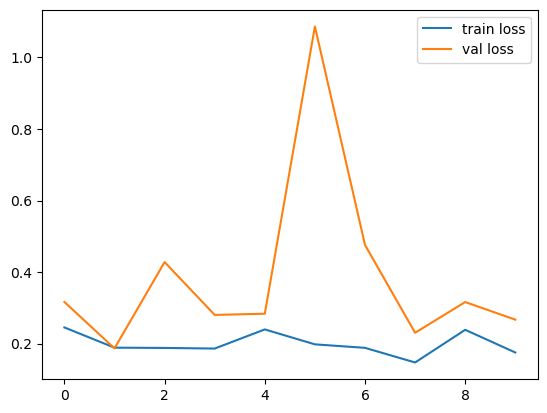

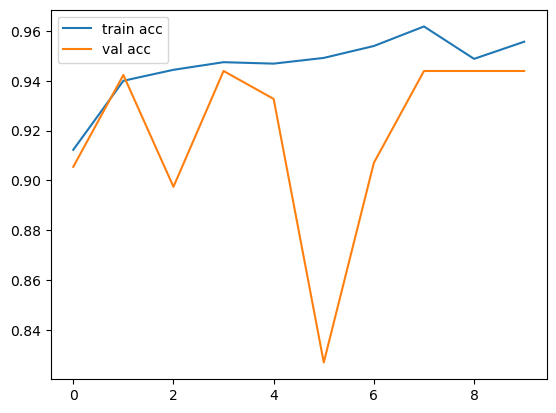

<Figure size 640x480 with 0 Axes>

In [15]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [16]:
from tensorflow.keras.models import load_model

model.save('model_vgg16.h5')

In [17]:
# model = load_model('model_vgg16.h5')

In [19]:
y_pred = model.predict(test_set)

78/78 ━━━━━━━━━━━━━━━━━━━━ 59s 755ms/step


In [20]:
y_pred

array([[1.3650464e-10, 1.0000000e+00],
       [2.3640555e-06, 9.9999762e-01],
       [8.3031773e-06, 9.9999166e-01],
       ...,
       [3.0530698e-06, 9.9999690e-01],
       [5.4838642e-06, 9.9999452e-01],
       [1.4977654e-03, 9.9850219e-01]], dtype=float32)

In [21]:
pred = np.argmax(y_pred , axis=1)

In [22]:
pred

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,

In [33]:
img=image.load_img('dataset/test/PNEUMONIA/BACTERIA-40699-0002.jpeg',target_size=(224,224))

In [34]:
x=image.img_to_array(img)
x

array([[[ 8.,  8.,  8.],
        [12., 12., 12.],
        [15., 15., 15.],
        ...,
        [77., 77., 77.],
        [76., 76., 76.],
        [72., 72., 72.]],

       [[12., 12., 12.],
        [16., 16., 16.],
        [18., 18., 18.],
        ...,
        [80., 80., 80.],
        [78., 78., 78.],
        [84., 84., 84.]],

       [[17., 17., 17.],
        [22., 22., 22.],
        [28., 28., 28.],
        ...,
        [81., 81., 81.],
        [80., 80., 80.],
        [76., 76., 76.]],

       ...,

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]

In [35]:
x.shape

(224, 224, 3)

In [36]:
x=x/255.0

In [27]:
x.shape

(224, 224, 3)

In [37]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [38]:
model.predict(img_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


array([[2.7118784e-05, 9.9997294e-01]], dtype=float32)

In [39]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


In [40]:
a

array([1])

In [41]:
if a ==1:
    print('The Chest - Xray has pneumonia')
else:
    print('The Chest - Xray is normal')

The Chest - Xray has pneumonia


In [47]:
loss, accuracy = model.evaluate(test_set)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 62s 797ms/step - accuracy: 0.9387 - loss: 0.3444
Test Loss: 0.26688656210899353
Test Accuracy: 0.9439102411270142
